# Capacitated facility location problem

## Problem Description

The capacitated facility location problem is the basis for many practical optimization problems, where the total demand that each facility may satisfy is limited. Hence, modeling such problem must take into account both demand satisfaction and capacity constraints.

Let us start with a concrete example. Consider a company with three potential sites for installing its facilities/warehouses and five demand points, as in Section Transportation Problem. Each site $j$ has a yearly activation cost $f_j$, i.e., an annual leasing expense that is incurred for using it, independently of the volume it services. This volume is limited to a given maximum amount that may be handled yearly, $M_j$. Additionally, there is a transportation cost $c_{ij}$ per unit serviced from facility $j$ to the demand point $i$. These data are shown in Table Data for the facility location problem: **demand, transportation costs, fixed costs, and capacities..**
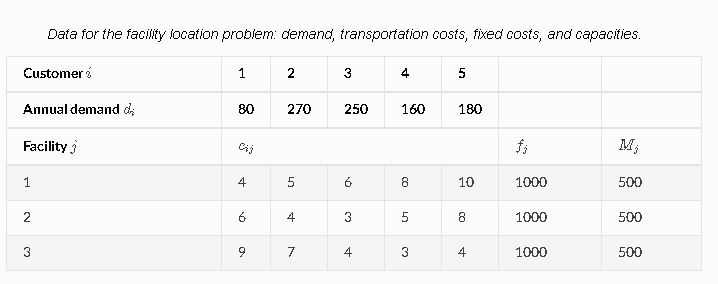

## Model Formulation

### Sets and Indices

$i \in I$: Index and set of supermarket (or customer) locations.

$j \in J$: Index and set of candidate warehouse (or facility) locations.

### Parameters

$f_{j} \in \mathbb{R}^+$: Fixed cost associated with constructing facility $j \in J$.

$d_{i,j} \in \mathbb{R}^+$: Distance between facility $j \in J$ and customer $i \in I$.

$M_j \in \mathbb{R}^+$: The capacity of facility $j \in J $

$c_{i,j} \in \mathbb{R}^+$: Cost of shipping between candidate facility site $j \in J$ and customer location $i \in I$. We assume that this cost is proportional to the distance between the facility and the customer. That is, $c_{i,j} = \alpha \cdot d_{i,j}$, where $\alpha$ is the cost per mile of driving, adjusted to incorporate the average number of trips a delivery truck would be expected to make over a five year period.

### Decision Variables

$select_{j} \in \{0, 1 \}$: This variable is equal to 1 if we build a facility at candidate location $j \in J$; and 0 otherwise.

$0 \leq assign_{i,j} \leq 1$: This non-negative continuous variable determines the fraction of supply received by customer $i \in I$ from facility $j \in J$.

### Objective Function

- **Total costs**. We want to minimize the total cost to open and operate the facilities. This is the sum of the cost of opening facilities and the cost related to shipping between facilities and customers. This total cost measures the tradeoff between the cost of building a new facility and the total delivery cost over a five year period.

\begin{equation}
\text{Min} \quad Z = \sum_{j \in J} f_{j} \cdot select_{j} + \sum_{j \in J} \sum_{i \in I} c_{i,j} \cdot assign_{i,j}
\tag{0}
\end{equation}

### Constraints

- **Demand**. For each customer  $i \in I$ ensure that its demand is fulfilled. That is, the sum of the fraction received from each facility for each customer must be equal to 1:

\begin{equation}
\sum_{j \in J} assign_{i,j} = 1 \quad \forall i \in I
\tag{1}
\end{equation}

- **Shipping**. We need to ensure that we  only ship from facility $j \in J$,  if that facility has actually been built.

\begin{equation}
assign_{i,j} \leq select_{j} \quad \forall i \in I \quad \forall j \in J
\tag{2}
\end{equation}


- **Capacity**. For each warehouse  $j \in J$ ensure that its capacity is not exceeded. That is, the sum of the shipping received from each facility for each customer must not exceed the capacity of that facility:
\begin{equation}
assign_{i,j} \leq select_{j} \cdot M_j \quad \forall i \in I \quad \forall j \in J
\tag{2}
\end{equation}

## Python Implementation
#### Using Gurobi Python module and other Python libraries

In [1]:
from math import sqrt
import gurobipy as gp
from gurobipy import GRB

#Parameters
customers = [0, 1, 2, 3, 4]
warehouses = [0, 1, 2]
setup_cost = [1000, 1000, 1000]
capacity = [500, 500, 500]
demand = [80, 270, 250, 160, 180]

cost = { (warehouses[0],customers[0]):4, (warehouses[0],customers[1]):5, (warehouses[0],customers[2]):6, (warehouses[0],customers[3]):8, (warehouses[0],customers[4]):10,
         (warehouses[1],customers[0]):6, (warehouses[1],customers[1]):4, (warehouses[1],customers[2]):3, (warehouses[1],customers[3]):5, (warehouses[1],customers[4]):8,
         (warehouses[2],customers[0]):9, (warehouses[2],customers[1]):7, (warehouses[2],customers[2]):4, (warehouses[2],customers[3]):3, (warehouses[2],customers[4]):4
       }


In [2]:
# Compute key parameters of MIP model formulation
num_warehouses = len(warehouses)
num_customers = len(customers)
cartesian_prod = list(product( range(num_warehouses), range(num_customers)))

In [3]:
m = gp.Model("facility_location")

select = m.addVars(num_warehouses, vtype=GRB.BINARY, name='Select')
assign = m.addVars(cartesian_prod, name='Assign')

#Demand Constraint: Ensures each customers demand is satisfied
m.addConstrs((gp.quicksum(assign[(w,c)] for w in range(num_warehouses)) == demand[c] for c in range(num_customers)), name='Demand')

#capacity constraint
m.addConstrs((gp.quicksum(assign[w,c] for c in range(num_customers)) <= capacity[w]*select[w] for w in range(num_warehouses)), name="Capacity")

#shipping
m.addConstrs((assign[(w,c)] <= select[w]*demand[w] for w,c in cartesian_prod), name='source2sink')


#OBJECTIVE FUNCTION
obj = m.setObjective(select.prod(setup_cost)+assign.prod(cost), GRB.MINIMIZE)

m.optimize()



Set parameter Username
Academic license - for non-commercial use only - expires 2022-08-05
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 2 physical cores, 2 logical processors, using up to 2 threads
Optimize a model with 23 rows, 18 columns and 63 nonzeros
Model fingerprint: 0x91391506
Variable types: 15 continuous, 3 integer (3 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+02]
  Objective range  [3e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e+01, 3e+02]
Presolve removed 11 rows and 2 columns
Presolve time: 0.00s
Presolved: 12 rows, 16 columns, 35 nonzeros
Variable types: 15 continuous, 1 integer (1 binary)
Found heuristic solution: objective 6370.0000000

Root relaxation: objective 5.610000e+03, 3 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    56

In [4]:
for warehouse in select.keys():
    if (abs(select[warehouse].x) > 1e-6):
        print(f"\n Build a warehouse at location {warehouse + 1}.")


 Build a warehouse at location 2.

 Build a warehouse at location 3.


In [5]:
# Shipments from facilities to customers.

for warehouse, customer in assign.keys():
    if (abs(assign[warehouse, customer].x) > 1e-6):
        print(f"\n Customer {customer + 1} receives {assign[warehouse, customer].x} of its demand  from Warehouse {warehouse + 1} .")



 Customer 1 receives 80.0 of its demand  from Warehouse 2 .

 Customer 2 receives 270.0 of its demand  from Warehouse 2 .

 Customer 3 receives 150.0 of its demand  from Warehouse 2 .

 Customer 3 receives 100.0 of its demand  from Warehouse 3 .

 Customer 4 receives 160.0 of its demand  from Warehouse 3 .

 Customer 5 receives 180.0 of its demand  from Warehouse 3 .
